In [127]:
#imports and functions - run me

import sys
sys.path.append('/dls_sw/apps/scisoftpy/2.7')
sys.path.append('/dls_sw/i16/software/python')
from dlstools.dataloader import *
from dlstools import *
from matplotlib.pyplot import *

from dlstools.tictoc import tictoc
tt = tictoc()

out_folder = '/dls/science/users/spc93/pdc/'
close('all')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_rows',18)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def get_files_and_start_times(path,labelstr):
    
    #debug code -delete
    print path, labelstr
    ###################
    
    files=[]; times=[]
    file_list=os.listdir(path); file_list.sort();
    for file in file_list:
        firstline=pd.read_csv(path+file, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'], nrows=1)
        try:
            times+=[firstline.ToA[0]]
            files+=[file]
        except:
            print "no data: File:", file
    
    df=pd.DataFrame({'files'+labelstr:files, 'ToA'+labelstr:times})
    df['sec'+labelstr]=df['ToA'+labelstr]*2e-9;    df['mins'+labelstr]=df['sec'+labelstr]/60.0;    df['hours'+labelstr]=df['mins'+labelstr]/60.0;
    return df
   
def get_all_file_pairs_old(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    all=top_files_times.join(bot_files_times)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def get_all_file_pairs(path_top, path_bot):      
    top_files_times=get_files_and_start_times(path_top,'0')
    bot_files_times=get_files_and_start_times(path_bot,'1')
    bot_files_times_aligned=bot_files_times.copy()
    for ii in range(len(top_files_times)):
        sec0=top_files_times['sec0'][ii]
        idx=np.abs(bot_files_times.sec1-sec0).idxmin() #find index of closest start time of bot to top
        bot_files_times_aligned.loc[ii] = bot_files_times.loc[idx]
    all=top_files_times.join(bot_files_times_aligned)
    all['ToA_offset']=all.ToA1-all.ToA0
    all['TimeOffsetSec']=all['ToA_offset']*2e-9
    return all


def find_coincidences_old(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
        coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        tb_coinc=tb[coinc_events]
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)
        tb_both=tb_coinc.join(tb_coinc_previous)
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
    all_coinc.reset_index()
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    return all_coinc.astype(int)



def find_coincidences(path_top, path_bot, file_pair_table, file_num_list, coinc_time, coinc_range, remove_adjacent=True, return_all_minus_any_coinc=False, plot_histogram=False):
    #coinc_time=10   #count as coincidence if within this value
    #coinc_range=50  #plot range for time histograms
    #remove_adjacent: remove if there is a coincidence with the previous or next event (attempt at removing charge-sharing)
    #plot_histogram: plot coincidences as histogram (slow!)
    
    num_events=0
    num_coinc=0
    for filepairnum in file_num_list:
        print "=== Starting file pair %i" % filepairnum
        t=pd.read_csv(path_top+file_pair_table.files0[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        b=pd.read_csv(path_bot+file_pair_table.files1[filepairnum], sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
        t['Module']=0; b['Module']=1
        b.I, b.J=255-b.I, 255*2-b.J
        tb=pd.concat([t,b]) #joint modules to make one big detector
        tb.sort_values('ToA',inplace=True)
        tb.ToA=tb.ToA-tb.ToA.min()
        tb['Tdiff']=tb.ToA-tb.ToA.shift(1)
        tb['Mdiff']=tb.Module-tb.Module.shift(1)
        tb['TdiffM']=tb.Tdiff/tb.Mdiff             #ToA difference: +ve if 0 first then 1; -ve if 1 then 0, inf if same module
        tb['Prev_coinc']=abs(tb.ToA-tb.ToA.shift(2))<=coinc_range
        tb['Next_coinc']=abs(tb.ToA-tb.ToA.shift(-1))<=coinc_range
        coinc_events_range=abs(tb.TdiffM)<=coinc_range #events within coinc_range (for plot)
        tb_coinc_range=tb[coinc_events_range]
        if plot_histogram:
            tb_coinc_range.plot(y='TdiffM',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences

        if not return_all_minus_any_coinc: #normal coincidence calculation
            if remove_adjacent: #coincidences are events between different modules where no coicidence in adjacent events
                #coinc_events=abs(tb.TdiffM)<=coinc_time & ~tb['Prev_coinc'] & ~tb['Next_coinc']
                coinc_events = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
                #tb['BeTrue'] = (abs(tb.TdiffM)<=coinc_time) & (tb['Prev_coinc']==False) & (tb['Next_coinc']==False)
            else: #coincidences are events between different modules 
                coinc_events=abs(tb.TdiffM)<=coinc_time #events within coinc_time (for coincidence data)
        else:#exclude coincidence
            print "======== exlude coinc", return_all_minus_any_coinc ############
            coinc_events = (abs(tb.Tdiff)<=coinc_time)==False
              
        tb_coinc=tb[coinc_events]
        
        #print 'a', len(tb_coinc)
        
        print '=== No. events:', len(tb)
        print '=== No. coinc. events:', len(tb_coinc)
        #print coinc_events ######################### delete
        tb_coinc_previous=tb.shift(1)[coinc_events]
        del tb_coinc_previous['Tdiff']; del tb_coinc_previous['Mdiff']; del tb_coinc_previous['TdiffM']; 
        del tb_coinc_previous['Prev_coinc']; del tb_coinc_previous['Next_coinc']; 
        #del tb_coinc_previous['BeTrue'];
       
        tb_coinc_previous.rename(columns={'I':'I0','J':'J0','ToA':'ToA0','ToT':'ToT0','Module':'Module0'}, inplace=True)

        #print 'b', len(tb_coinc_previous)
        #print tb_coinc
        #print tb_coinc_previous
        
        #print 'b+', len(tb_coinc)
        #tb_both=tb_coinc.join(tb_coinc_previous) ######## bad!
        #tb_both=pd.merge(tb_coinc, tb_coinc_previous) ###### any better?
        tb_both=pd.concat([tb_coinc, tb_coinc_previous], axis=1)
        
        #print "tb_coinc, tb_coinc_previous, tb_both"
        #print tb_coinc
        #print tb_coinc_previous
        #print tb_both     
        #print 'b++', len(tb_both)
        #print num_events
        
        if num_events==0:
            all_coinc=tb_both.copy(deep=True)
        else:
            all_coinc=all_coinc.append(tb_both)
        num_events+=len(t)+len(b)
        num_coinc+=len(tb_both)
        
        #print 'c', len(all_coinc)
        
    all_coinc.reset_index()
    
    #print 'd', len(all_coinc)
    
    print "===Total events : %i\tCoincidence : %i\t Percentage of coincidences: %.3f" % (num_events, num_coinc, num_coinc*100./num_events)       
    #return all_coinc.astype(int) # fails if NaN
    return all_coinc
    #return tb ######## test


def sequential_roi_list(isize, jsize, idivisions, jdivisions):
    iwidth, jwidth=isize/idivisions, jsize/jdivisions 
    roilist=[]
    for ni in range(idivisions):
        for nj in range(jdivisions):  
            roilist+=[[[ni*iwidth,(ni+1)*iwidth-1],[nj*jwidth,(nj+1)*jwidth-1]]]
    return roilist
    
def mk_image1(event_table, isize, jsize):
    mtot=np.zeros([isize, jsize])
    for i in range(len(event_table)):
        mtot[event_table.I.iloc[i], event_table.J.iloc[i]]+=1   #event in roi
        mtot[event_table.I0.iloc[i], event_table.J0.iloc[i]]+=1 #event in coincidence
    return mtot


In [2]:
#settings for 12/12/16 data

min_entries=1000000 #files with fewer entries (photons) not used
datadict={'run1and5':range(2,106)+range(973,1009),
          '50M':range(4,108)+range(485,726),
          '100M':range(280,483)+range(720,972),
          'nobeam':range(112,276)} 
#datadict={'run1and5':range(22,25)} # small test set
#dataset='run1and5'
dataset='50M'

#datapath='/media/spc93/Data/data/I16_Timepix3/'
#datapath='/media/sf_data/I16_Timepix3/'
datapath='/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted'
#datafolder_top='/20161212_I16_W2J2_TOP_Decoded/'
#datafolder_bot='/20161212_I16_W5I6_BOT_Decoded/'
datafolder_top='/20161212_I16_W2J2_TOP_Decoded_Sorted/'
datafolder_bot='/20161212_I16_W5I6_BOT_Decoded_Sorted/'


Sun Dec  2 12:20:05 2018 Elapsed time: 3154.04288793
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted/ 0
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted/ 1
Sun Dec  2 12:20:21 2018 Elapsed time: 3169.78374887
=== Starting file pair 4
=== No. coinc. events: 2878
=== Starting file pair 5
=== No. coinc. events: 2861
=== Starting file pair 6
=== No. coinc. events: 3006
=== Starting file pair 7
=== No. coinc. events: 3007
=== Starting file pair 8
=== No. coinc. events: 2914
=== Starting file pair 9
=== No. coinc. events: 2860
=== Starting file pair 10
=== No. coinc. events: 2857
=== Starting file pair 11
=== No. coinc. events: 2960
=== Starting file pair 12
=== No. coinc. events: 2962
=== Starting file pair 13
=== No. coinc. events: 2891
=== Starting file pair 14
=== No. coinc. events: 2980
=== Starting file pair 15
=== No. coinc. events: 3011
=== Starting file pair 16
=== No. coinc. events: 2901
==

=== No. coinc. events: 2775
=== Starting file pair 527
=== No. coinc. events: 2762
=== Starting file pair 528
=== No. coinc. events: 2735
=== Starting file pair 529
=== No. coinc. events: 2663
=== Starting file pair 530
=== No. coinc. events: 2605
=== Starting file pair 531
=== No. coinc. events: 2870
=== Starting file pair 532
=== No. coinc. events: 2863
=== Starting file pair 533
=== No. coinc. events: 2858
=== Starting file pair 534
=== No. coinc. events: 2862
=== Starting file pair 535
=== No. coinc. events: 2678
=== Starting file pair 536
=== No. coinc. events: 2751
=== Starting file pair 537
=== No. coinc. events: 2714
=== Starting file pair 538
=== No. coinc. events: 2679
=== Starting file pair 539
=== No. coinc. events: 2767
=== Starting file pair 540
=== No. coinc. events: 2668
=== Starting file pair 541
=== No. coinc. events: 2877
=== Starting file pair 542
=== No. coinc. events: 2741
=== Starting file pair 543
=== No. coinc. events: 2862
=== Starting file pair 544
=== No. co

=== No. coinc. events: 2715
=== Starting file pair 676
=== No. coinc. events: 2811
=== Starting file pair 677
=== No. coinc. events: 2668
=== Starting file pair 678
=== No. coinc. events: 2802
=== Starting file pair 679
=== No. coinc. events: 2632
=== Starting file pair 680
=== No. coinc. events: 2794
=== Starting file pair 681
=== No. coinc. events: 2697
=== Starting file pair 682
=== No. coinc. events: 2774
=== Starting file pair 683
=== No. coinc. events: 2775
=== Starting file pair 684
=== No. coinc. events: 2761
=== Starting file pair 685
=== No. coinc. events: 2831
=== Starting file pair 686
=== No. coinc. events: 2658
=== Starting file pair 687
=== No. coinc. events: 2697
=== Starting file pair 688
=== No. coinc. events: 2654
=== Starting file pair 689
=== No. coinc. events: 2669
=== Starting file pair 690
=== No. coinc. events: 2606
=== Starting file pair 691
=== No. coinc. events: 2712
=== Starting file pair 692
=== No. coinc. events: 2722
=== Starting file pair 693
=== No. co

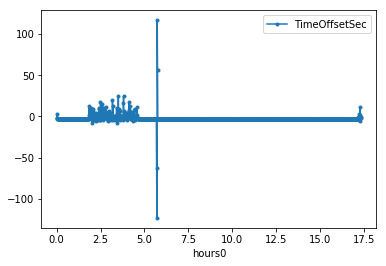

In [6]:
#processing 12/12/16 data

#find coincidences and save to hdf5 - do this once only
# get files corresponding to simultaneous pairs. Write to spreadsheet
print tt
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
allfiles.plot('hours0','TimeOffsetSec',  marker='.' ); axis('tight')
plt.savefig(out_folder+'plot1.pdf')
writer=pd.ExcelWriter(out_folder+'allfiles.xlsx')
allfiles.to_excel(writer)
writer.save()

print tt
#all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset][0:8], 10, 50, 
#                            remove_adjacent=True, plot_histogram=False)
all_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset], 10, 50, 
                            remove_adjacent=False, plot_histogram=False)
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
store['all_coinc']=all_coinc
store.close()
print tt


In [5]:
all_coinc

,I,J,ToA,ToT,Module,Tdiff,Mdiff,TdiffM,Prev_coinc,Next_coinc,I0,J0,ToA0,ToT0,Module0
457,39,113,1609320803,555,0,3,-1,-3,0,0,80,333,1609320800,430,1
495,102,245,1609871945,485,0,7,-1,-7,0,0,109,346,1609871938,412,1
5820,37,113,1683079923,443,0,5,-1,-5,0,0,119,377,1683079918,112,1
6335,127,237,1690641248,686,0,2,-1,-2,0,0,167,346,1690641246,352,1
11657,107,57,1764994689,445,0,9,-1,-9,0,0,138,461,1764994680,422,1
13768,127,254,1793996610,620,0,3,-1,-3,0,0,153,370,1793996607,431,1
30169,4,207,2016742290,412,0,6,-1,-6,0,0,135,484,2016742284,370,1
31005,175,241,2027496815,543,0,8,-1,-8,0,0,7,373,2027496807,423,1
39686,196,183,2148062146,492,0,10,-1,-10,0,0,186,305,2148062136,390,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Fri Dec  7 10:23:24 2018 Elapsed time: 428152.533654
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W2J2_TOP_Decoded_Sorted/ 0
/dls/i16/data/2017/mt16227-1/processing/12_12_2016/Sorted/20161212_I16_W5I6_BOT_Decoded_Sorted/ 1


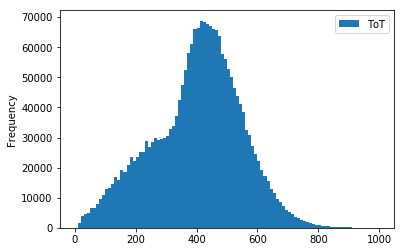

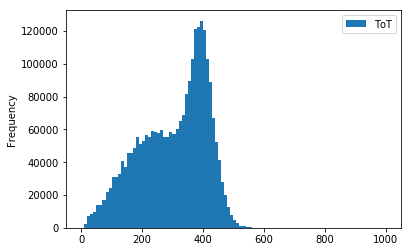

In [50]:
#processing 12/12/16 data
#energy spec

dataset='50M'

print tt
allfiles=get_all_file_pairs(datapath+datafolder_top, datapath+datafolder_bot)
file0 = allfiles['files0'][datadict[dataset][0]]    #    use just first file selected from file pairs
file1 = allfiles['files1'][datadict[dataset][0]]
# takes over 200 sec so comment out
t=pd.read_csv(datapath+datafolder_top+file0, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
b=pd.read_csv(datapath+datafolder_bot+file1, sep='\t', usecols=[0,1,2,3], names=['I','J','ToA','ToT'])
t.plot(y='ToT',kind='hist', bins=range(0,1001,10))
b.plot(y='ToT',kind='hist', bins=range(0,1001,10))
#bad low-energy tail. top has worse energy resolution
#approx. chans for both: main 300-600; half 150-300
#top fwhm 360-540
#bot fwhm 340-440
#sum of two should be around 350-490

In [49]:
dataset

'50M_rem_adj_false'

In [40]:
dataset='50M_rem_adj_false'
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back


Wed Dec  5 20:25:46 2018 Elapsed time: 291494.552064
Wed Dec  5 20:25:46 2018 Elapsed time: 291495.234843
Wed Dec  5 20:26:03 2018 Elapsed time: 291512.143784


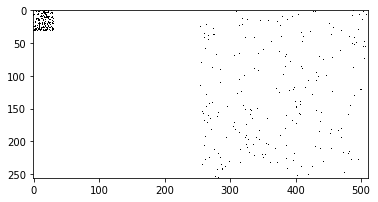

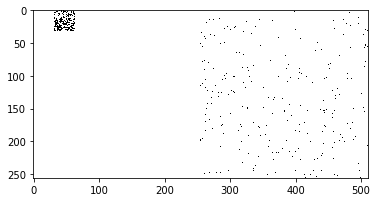

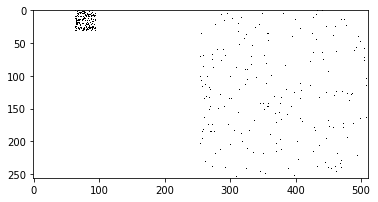

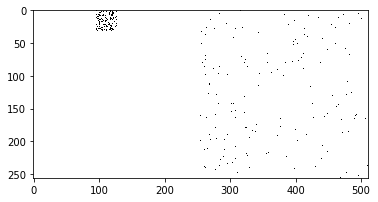

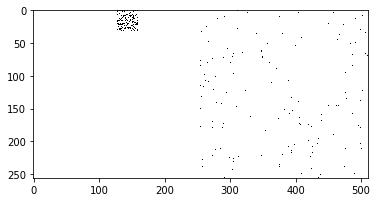

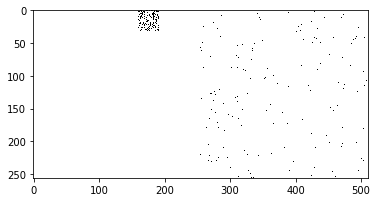

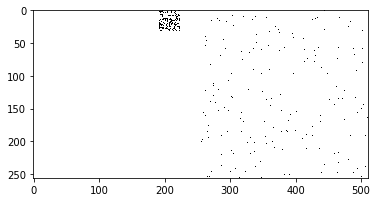

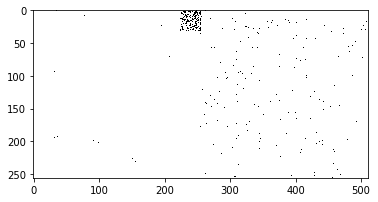

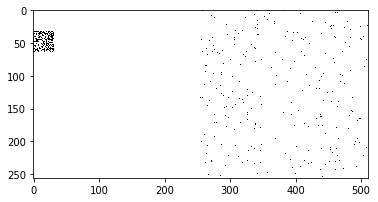

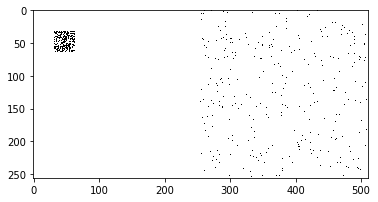

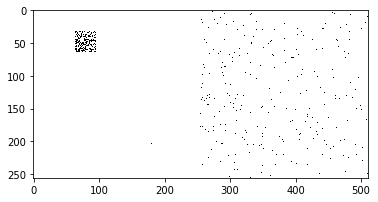

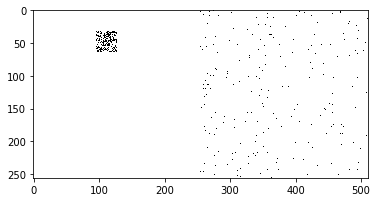

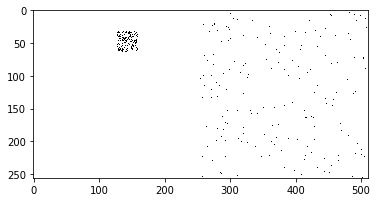

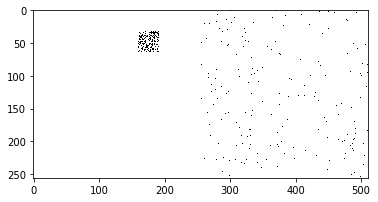

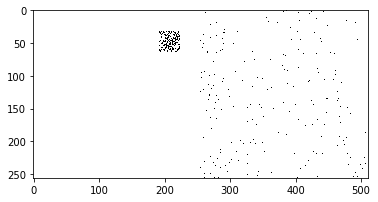

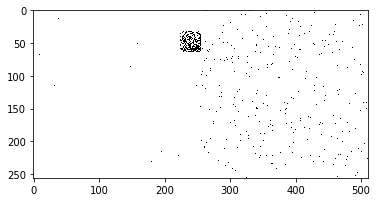

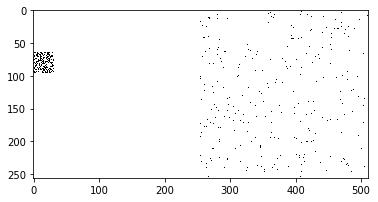

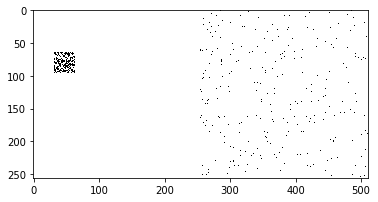

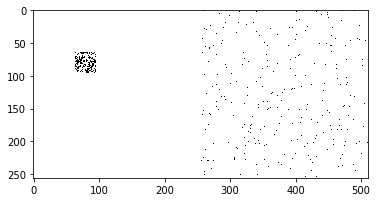

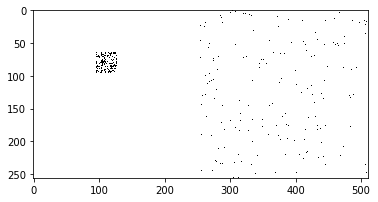

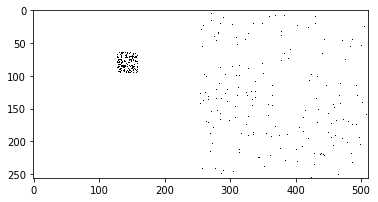

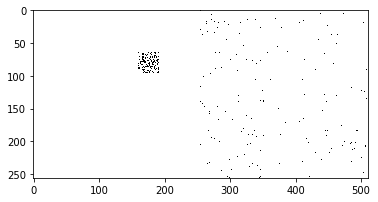

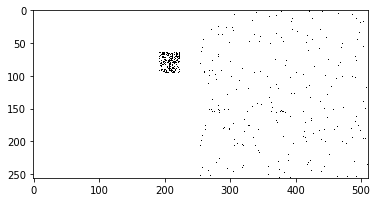

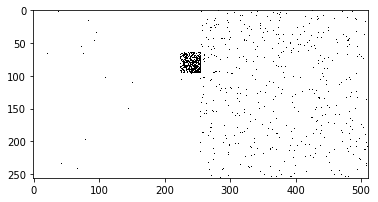

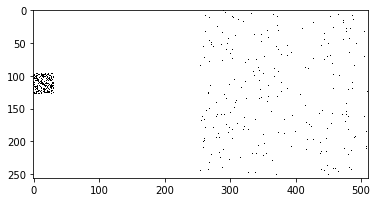

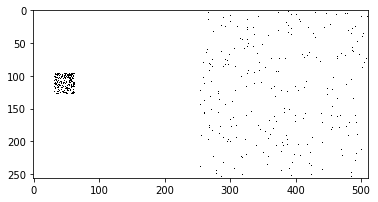

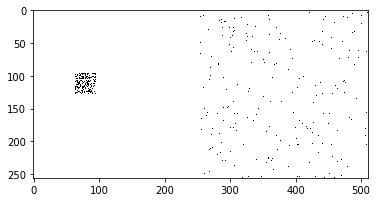

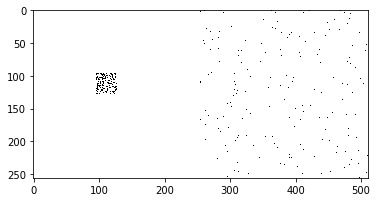

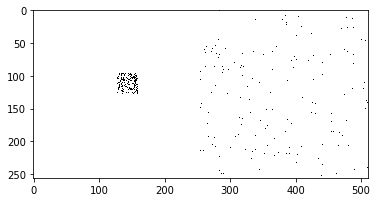

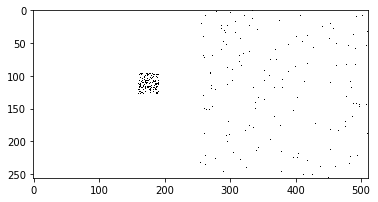

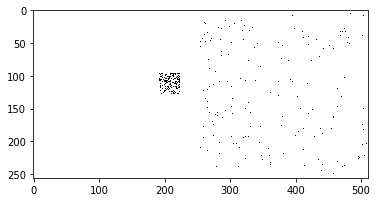

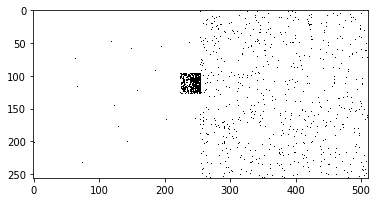

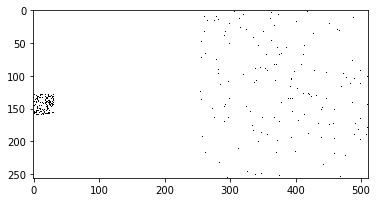

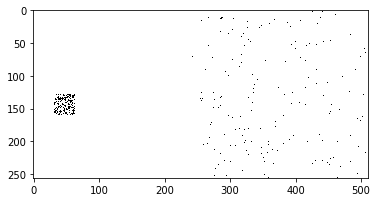

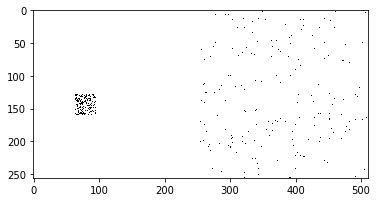

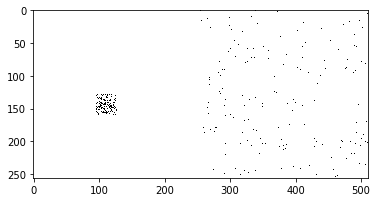

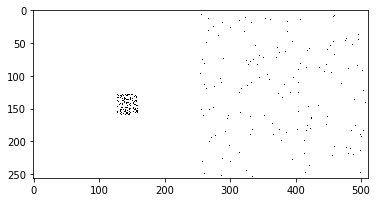

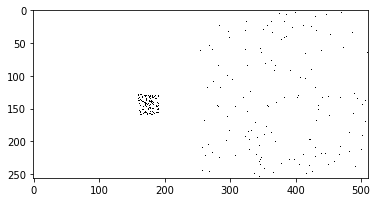

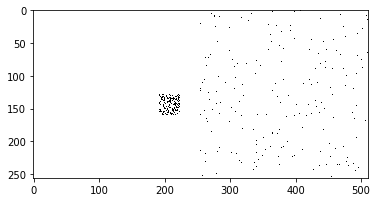

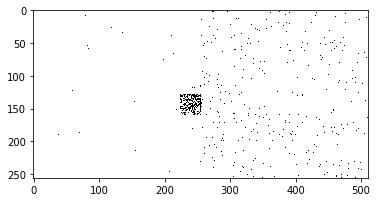

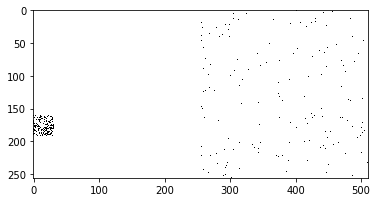

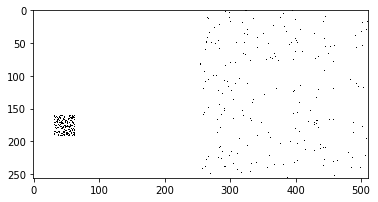

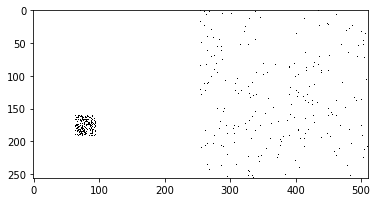

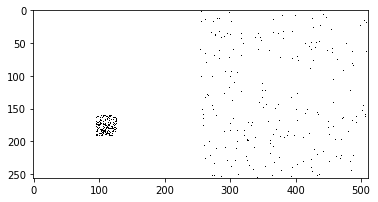

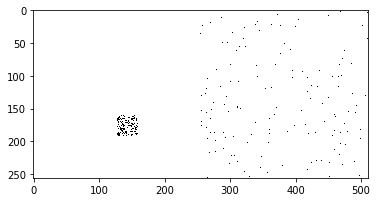

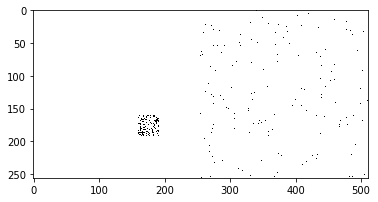

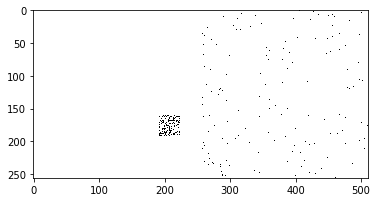

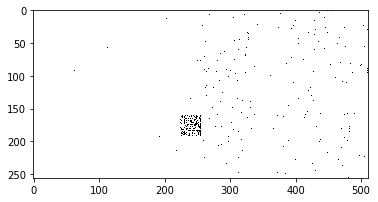

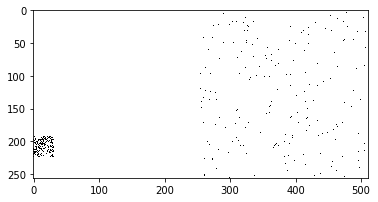

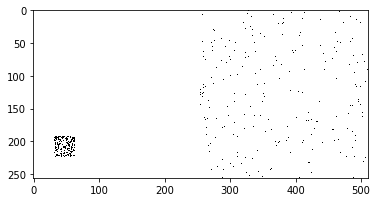

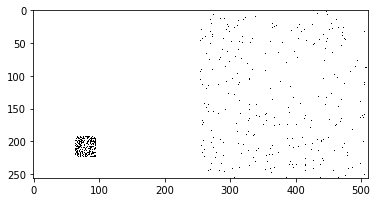

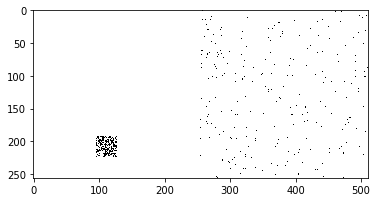

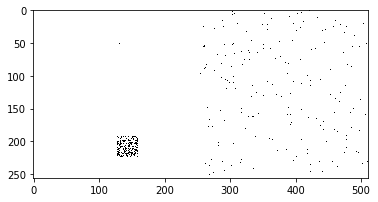

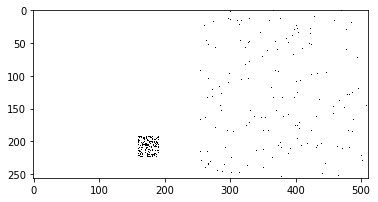

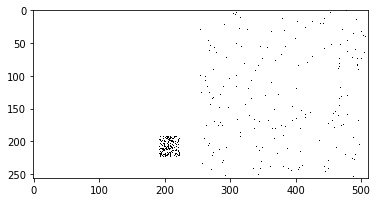

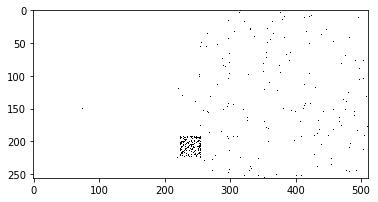

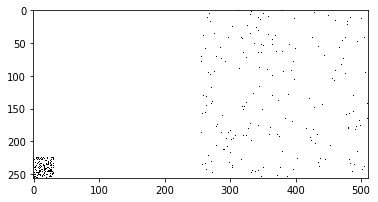

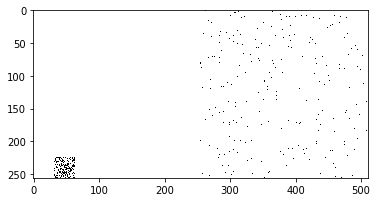

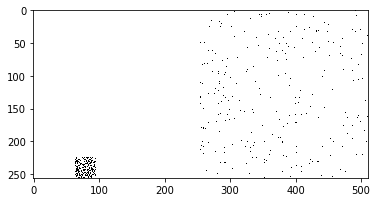

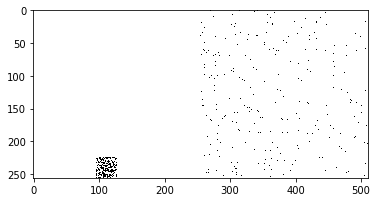

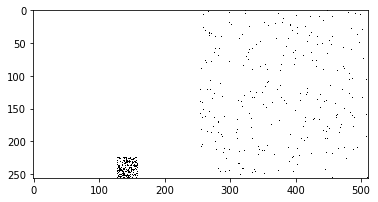

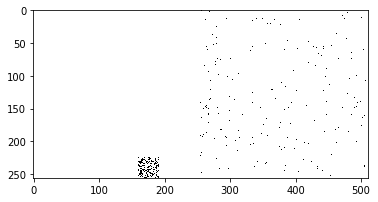

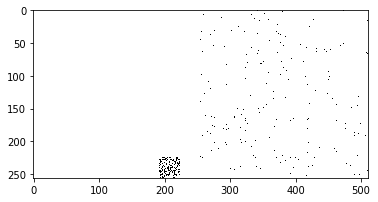

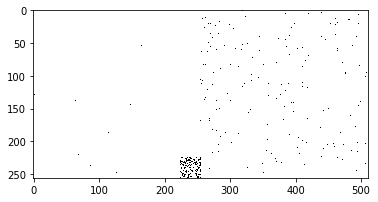

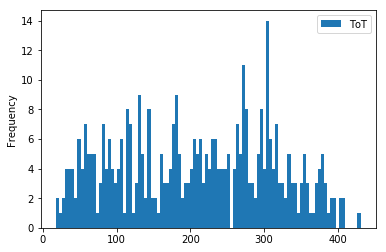

In [41]:
#analyse coincidence data from h5 
#### run first cell first
print tt
store = pd.HDFStore(datapath+'/'+dataset+'.h5')
all_coinc=store['all_coinc']; #load it back
isize=max(all_coinc.I+1)
jsize=max(all_coinc.J+1)



#filter
roilist=sequential_roi_list(256,256,8,8)
print tt
for roi in roilist:
    #roi=roilist[36] #single roi in middle
    #time only
    #coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) & (all_coinc.J<=roi[1][1]) ]
    #time and energy
    coinc=all_coinc[(all_coinc.I>=roi[0][0]) & (all_coinc.I<=roi[0][1]) & (all_coinc.J>=roi[1][0]) 
        & (all_coinc.J<=roi[1][1]) &  ((all_coinc.ToT+all_coinc.ToT0)>350)  & ((all_coinc.ToT+all_coinc.ToT0)<475)]
    #create image
    im_coinc=mk_image1(coinc, isize, jsize)
    plt.figure(); plt.imshow(im_coinc, cmap='Greys',vmax=1)
print tt
#coin.plot(y='ToT',kind='hist',bins=1+2*coinc_range, title='Pair No. '+str(filepairnum) ) #will crash if no coincidences
coinc.plot(y='ToT',kind='hist', bins=100)

=== Starting file pair 14
======== exlude coinc True
=== No. events: 4732258
=== No. coinc. events: 3859008
===Total events : 4732258	Coincidence : 3859008	 Percentage of coincidences: 81.547


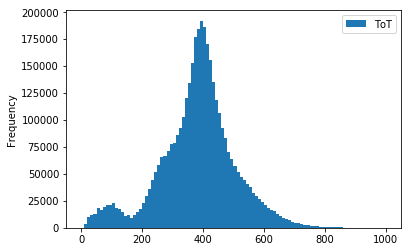

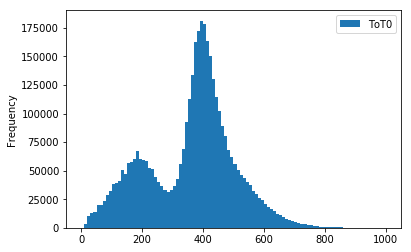

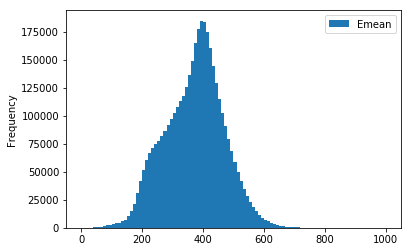

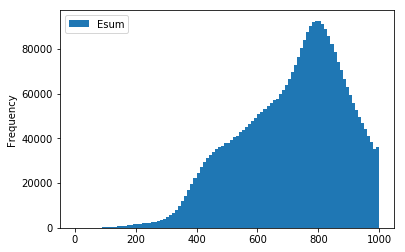

In [128]:
#processs single pair to remove coincidences
not_coinc=find_coincidences(datapath+datafolder_top, datapath+datafolder_bot, allfiles, datadict[dataset][10:11], 10, 50, 
                            return_all_minus_any_coinc=True, plot_histogram=False)
not_coinc.plot(y='ToT',kind='hist', bins=range(0,1001,10))
not_coinc.plot(y='ToT0',kind='hist', bins=range(0,1001,10))
not_coinc['Emean'] = (not_coinc.ToT + not_coinc.ToT0)/2
not_coinc['Esum'] = (not_coinc.ToT + not_coinc.ToT0)
not_coinc.plot(y='Emean',kind='hist', bins=range(0,1001,10))
not_coinc.plot(y='Esum',kind='hist', bins=range(0,1001,10))

In [43]:
1744./(len(range(4,108)+range(485,726))*2.1e6)

2.407177363699103e-06